### Домашнее задание к занятию «Тематическое моделирование»

### Классификация по тональности  
В этом домашнем задании вам предстоит классифицировать по тональности отзывы на банки с сайта banki.ru.

Данные содержат непосредственно тексты отзывов, некоторую дополнительную информацию, а также оценку по шкале от 1 до 5.

Тексты хранятся в json-ах в массиве responses.

Посмотрим на примере отзыва: возьмите для удобства ноутбук, размещенный в папке репозитория.

### Часть 1. Анализ текстов  
1. Посчитайте количество отзывов в разных городах и на разные банки  
2. Постройте гистограмы длин слов в символах и в словах  
3. Найдите 10 самых частых:  
- слов  
- слов без стоп-слов  
- лемм  
- существительных  

4. Постройте кривые Ципфа и Хипса  
5. Ответьте на следующие вопросы:  
- какое слово встречается чаще, "сотрудник" или "клиент"?  
- сколько раз встречается слова "мошенничество" и "доверие"?  

6. В поле "rating_grade" записана оценка отзыва по шкале от 1 до 5. Используйте меру tf - idf, для того, чтобы найти ключевые слова и биграмы для положительных отзывов (с оценкой 5) и отрицательных отзывов (с оценкой 1).

In [2]:
import json

import bz2
import regex
from tqdm import tqdm
from scipy import sparse

In [3]:
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [4]:
responses = []
with bz2.BZ2File('banki_responses.json.bz2', 'r') as thefile:
    for row in tqdm(thefile):
        resp = json.loads(row)
        if not resp['rating_not_checked'] and (len(resp['text'].split()) > 0):
            responses.append(resp)

201030it [01:47, 1867.04it/s]


In [5]:
responses[67]

{'city': 'г. Москва',
 'rating_not_checked': False,
 'title': 'Звонки по ночам.',
 'num_comments': 0,
 'bank_license': 'лицензия № 3279',
 'author': 'HAB728',
 'bank_name': 'Национальный Банк «Траст»',
 'datetime': '2015-06-07 21:37:17',
 'text': 'Уважаемый банк и г-жа станецкая, скажите, в какие рамки закона попадают звонки по ночам, в час ночи, в три ночи ...в выходные дни. Скрин не нашла как прицепить. Отправлю заодно в роскомнадзор и цб. \xa0Приятна забота, но услугу "разбуди меня" я не заказывала. Если только с завтраком в номер и на югах. А так не смешно, дамы и господа.',
 'rating_grade': None}

In [6]:
df = pd.DataFrame(data=responses)

In [7]:
df.head()

,city,rating_not_checked,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade
0,г. Москва,False,Жалоба,0,лицензия № 2562,uhnov1,Бинбанк,2015-06-08 12:50:54,Добрый день! Я не являюсь клиентом банка и пор...,NaN
1,г. Новосибирск,False,Не могу пользоваться услугой Сбербанк он-лайн,0,лицензия № 1481,Foryou,Сбербанк России,2015-06-08 11:09:57,Доброго дня! Являюсь держателем зарплатной кар...,NaN
2,г. Москва,False,Двойное списание за один товар.,1,лицензия № 2562,Vladimir84,Бинбанк,2015-06-05 20:14:28,Здравствуйте! Дублирую свое заявление от 03.0...,NaN
3,г. Ставрополь,False,Меняют проценты комиссии не предупредив и не ...,2,лицензия № 1481,643609,Сбербанк России,2015-06-05 13:51:01,Добрый день!! Я открыл расчетный счет в СберБа...,NaN
4,г. Челябинск,False,Верните денежные средства за страховку,1,лицензия № 2766,anfisa-2003,ОТП Банк,2015-06-05 10:58:12,"04.03.2015 г. взяла кредит в вашем банке, заяв...",NaN


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153499 entries, 0 to 153498
Data columns (total 10 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   city                138325 non-null  object 
 1   rating_not_checked  153499 non-null  bool   
 2   title               153499 non-null  object 
 3   num_comments        153499 non-null  int64  
 4   bank_license        153498 non-null  object 
 5   author              153479 non-null  object 
 6   bank_name           153499 non-null  object 
 7   datetime            153499 non-null  object 
 8   text                153499 non-null  object 
 9   rating_grade        88658 non-null   float64
dtypes: bool(1), float64(1), int64(1), object(7)
memory usage: 10.7+ MB


### Почему получаются разные значение?

In [9]:
print("Количество отзывов в разных городах:", df.city.nunique())

Количество отзывов в разных городах: 5823


In [10]:
print("Количество отзывов в разных городах:", len(df.city.unique()))

Количество отзывов в разных городах: 5824


In [11]:
print("Количество отзывов на разные банки:", len(df.bank_name.unique()))

Количество отзывов на разные банки: 670


In [12]:
print("Количество отзывов на разные банки:", df.bank_name.nunique())

Количество отзывов на разные банки: 670


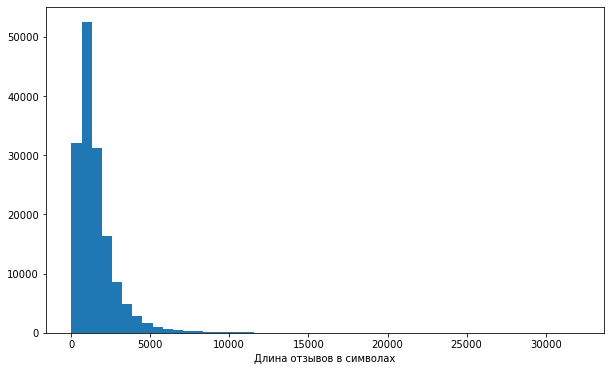

In [13]:
df.text.apply(len).plot(kind='hist',bins=50, figsize=(10, 6))
plt.xlabel('Длинa отзывов в символах')
plt.ylabel('')
plt.show()

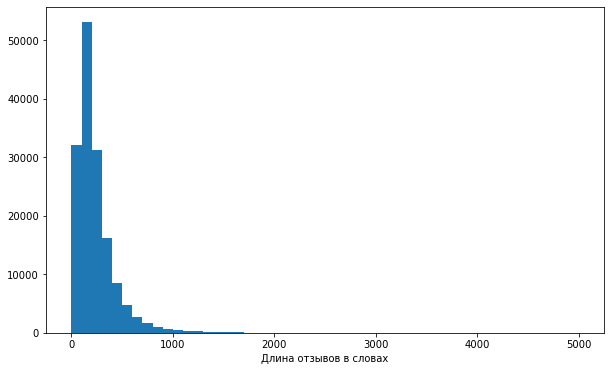

In [14]:
df.text.str.split().apply(len).plot(kind='hist',bins=50, figsize=(10, 6))
plt.xlabel('Длинa отзывов в словах')
plt.ylabel('')
plt.show()

In [15]:
from string import punctuation
from collections import Counter

In [16]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\cefeu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [137]:
noise = stopwords.words('russian') + list(punctuation) + ["``", "''", "...", ".", '»', '–']

In [207]:
!pip install pymorphy2

  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13723 sha256=76f782c1b6580fc9ad70c3f680eeb229283cc4e2ee0c042534c3e6bc5af3d6f6
  Stored in directory: c:\users\cefeu\appdata\local\pip\cache\wheels\70\4a\46\1309fc853b8d395e60bafaf1b6df7845bdd82c95fd59dd8d2b
Successfully built docopt


In [22]:
from pymorphy2 import MorphAnalyzer
pymorphy2_analyzer = MorphAnalyzer()
from nltk.tokenize import word_tokenize

Для ускорения, возьмем первые 10000 строк:

In [27]:
data = df.head(10000)

In [28]:
#Найдите 10 самых частых: слов
karp = [token for tweet in data.text.str.lower() for token in word_tokenize(tweet) if token not in punctuation]
popular10 = Counter(karp)

print("10 самых частых слов:")
popular10.most_common(10)

10 самых частых слов:


[('в', 74867),
 ('и', 60531),
 ('не', 49674),
 ('на', 41028),
 ('что', 35465),
 ('я', 33397),
 ('с', 27774),
 ('по', 22361),
 ('мне', 19029),
 ('банка', 16676)]

In [29]:
karp1 = [token for tweet in data.text.str.lower() for token in word_tokenize(tweet) if token not in noise]
popular10_1 = Counter(karp1)

print("10 самых частых слов без стоп слов:")
popular10_1.most_common(10)

10 самых частых слов без стоп слов:


[('банка', 16676),
 ('банк', 12868),
 ('это', 10107),
 ('деньги', 6986),
 ('карты', 5964),
 ('карту', 5618),
 ('день', 4711),
 ('кредит', 4631),
 ('заявление', 3933),
 ('банке', 3776)]

In [30]:
karp2 = [pymorphy2_analyzer.parse(token)[0].normal_form for tweet in data.text.str.lower() for token in tweet.split() if token not in noise]
popular10_2 = Counter(karp2)
print("10 самых частых лемм:")
popular10_2.most_common(10)

10 самых частых лемм:


[('банк', 25619),
 ('карта', 12532),
 ('мой', 10973),
 ('это', 10369),
 ('который', 8703),
 ('сотрудник', 7850),
 ('деньга', 6775),
 ('свой', 6216),
 ('кредит', 5913),
 ('сумма', 5537)]

In [31]:
karp3 = [token for token in karp2 if pymorphy2_analyzer.parse(token)[0].tag.POS == 'NOUN']
popular10_3 = Counter(karp3)
print("10 самых частых существительных:")
popular10_3.most_common(10)

10 самых частых существительных:


[('банк', 25619),
 ('карта', 12532),
 ('сотрудник', 7850),
 ('деньга', 6775),
 ('кредит', 5913),
 ('сумма', 5537),
 ('счёт', 5374),
 ('отделение', 5354),
 ('день', 5178),
 ('клиент', 4947)]

In [32]:
#Постройте кривые Ципфа и Хипса
corpus = [token for tweet in df.text.str.lower() for token in word_tokenize(tweet) if token not in punctuation]
mostpopular = Counter(corpus)

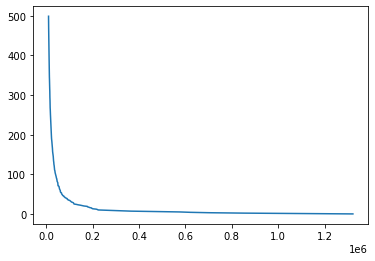

In [39]:
fregs = list(mostpopular.values())
freqs = sorted(fregs, reverse = True)

fig, ax = plt.subplots()
ax.plot(freqs[:500], range(500))
plt.show()

In [519]:
from tqdm import tqdm

cnt = Counter()
n_words = []
n_tokens = []
tokens = []
for index, row in tqdm(df.iterrows(), total = len(df)):
    tokens = word_tokenize(row['text'])
    cnt.update([token for token in tokens if token not in punctuation])
    n_words.append(len(cnt))
    n_tokens.append(sum(list(cnt.values())))

100%|████████████████████████████████████████████████████████████████████████| 153499/153499 [1:04:47<00:00, 39.49it/s]


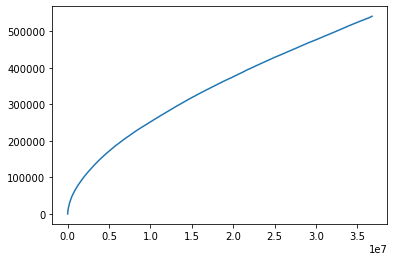

In [520]:
fig, ax = plt.subplots()
ax.plot(n_tokens, n_words)
plt.show()

Ответьте на следующие вопросы:
- какое слово встречается чаще, "сотрудник" или "клиент"?
- сколько раз встречается слова "мошенничество" и "доверие"?

In [40]:
print("Cлово сотрудник встречается", mostpopular['сотрудник'], "раз, что больше чем количество упоминаний слова клиент - ", mostpopular['клиент'])

Cлово сотрудник встречается 30994 раз, что больше чем количество упоминаний слова клиент -  17754


In [41]:
mostpopular['мошенничество']

1102

In [42]:
mostpopular['доверие']

1153

В поле "rating_grade" записана оценка отзыва по шкале от 1 до 5. Используйте меру tf - idf, для того, чтобы найти ключевые слова и биграмы для положительных отзывов (с оценкой 5) и отрицательных отзывов (с оценкой 1).

In [43]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [221]:
df_positive = df.loc[df['rating_grade'] == 5].head(10000)

In [222]:
positive = df_positive.text.str.lower().tolist()

In [223]:
lemmas_pos = [pymorphy2_analyzer.parse(word)[0].normal_form for word in (" ".join(map(str,positive))).split() if word not in noise]

In [224]:
vec = TfidfVectorizer(ngram_range=(1, 1), tokenizer=word_tokenize, stop_words=noise)
bow = vec.fit_transform(lemmas_pos)

In [238]:
idx = np.ravel(bow.sum(axis=0).argsort(axis=1))[::-1][:10]
top_10_words = np.array(vec.get_feature_names_out())[idx].tolist()
print("Ключевые униграммы для положительных отзывов:")
top_10_words

Ключевые униграммы для положительных отзывов:


['банк',
 'карта',
 'это',
 'очень',
 'который',
 'отделение',
 'день',
 'сотрудник',
 'кредит',
 'свой']

In [226]:
df_negative = df.loc[df['rating_grade'] == 1].head(10000)

In [227]:
negative = df_negative.text.str.lower().tolist()

In [228]:
lemmas_neg = [pymorphy2_analyzer.parse(word)[0].normal_form for word in (" ".join(map(str,negative))).split() if word not in noise]

In [257]:
bow12 = vec.fit_transform(lemmas_neg)

In [258]:
idx = np.ravel(bow12.sum(axis=0).argsort(axis=1))[::-1][:10]
top_10_words = np.array(vec.get_feature_names_out())[idx].tolist()
print("Ключевые униграммы для отрицательных отзывов:")
top_10_words

Ключевые униграммы для отрицательных отзывов:


['банк',
 'карта',
 'это',
 'который',
 'сотрудник',
 'отделение',
 'день',
 'деньга',
 'кредит',
 'заявление']

### Часть 2. Тематическое моделирование  
1. Постройте несколько тематических моделей коллекции документов с разным числом тем. Приведите примеры понятных (интерпретируемых) тем.  
2. Найдите темы, в которых упомянуты конкретные банки (Сбербанк, ВТБ, другой банк). Можете ли вы их прокомментировать / объяснить? Эта часть задания может быть сделана с использованием gensim.

In [319]:
from gensim.corpora import Dictionary
from gensim.models import TfidfModel
from gensim import similarities
import re
from gensim.models import lsimodel

In [309]:
ru_words = re.compile("[А-Яа-я]+")


def words_only(text):
    return " ".join(ru_words.findall(text))


def lemmatize(text):
    try: 
        return " ".join([pymorphy2_analyzer.parse(word)[0].normal_form for word in text.split()])
    except:
        return " "


def remove_stopwords(text, mystopwords = mystopwords):
    try:
        return " ".join([token for token in text.split() if not token in mystopwords])
    except:
        return ""

    
def preprocess(text):
    return remove_stopwords(lemmatize(words_only(text.lower())))

In [311]:
texte = data.text.str.lower().tolist()

In [313]:
text1 = []
for item in texte:
    text1.append(preprocess(item))

In [318]:
texts = [text.split() for text in text1]
dictionary = Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

In [320]:
tfidf = TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

In [328]:
lsi_1 = lsimodel.LsiModel(corpus=corpus_tfidf, id2word=dictionary, num_topics=30)

In [329]:
lsi_1.show_topics(5)

[(0,
  '0.193*"карта" + 0.138*"кредит" + 0.118*"деньга" + 0.116*"вклад" + 0.107*"счёт" + 0.105*"заявление" + 0.101*"сумма" + 0.099*"сотрудник" + 0.099*"отделение" + 0.097*"номер"'),
 (1,
  '0.251*"звонок" + -0.240*"вклад" + 0.231*"номер" + -0.216*"карта" + 0.208*"кредит" + 0.177*"ваш" + 0.142*"телефон" + 0.136*"данные" + 0.134*"персональный" + -0.132*"деньга"'),
 (2,
  '0.617*"вклад" + -0.220*"карта" + 0.168*"договор" + -0.162*"банкомат" + 0.161*"ставка" + -0.158*"сбербанк" + 0.135*"условие" + 0.127*"процент" + 0.118*"страховка" + -0.109*"операция"'),
 (3,
  '-0.337*"страховка" + -0.301*"кредит" + 0.299*"вклад" + -0.247*"страхование" + 0.206*"номер" + 0.145*"звонок" + -0.138*"погашение" + -0.133*"платёж" + -0.131*"договор" + -0.130*"сумма"'),
 (4,
  '0.229*"средство" + 0.208*"денежный" + 0.184*"договор" + -0.180*"заявка" + 0.165*"вклад" + 0.143*"счёт" + 0.132*"сумма" + 0.125*"руб" + 0.123*"г" + 0.112*"рф"')]

In [334]:
lsi_2 = lsimodel.LsiModel(corpus=corpus_tfidf, id2word=dictionary, num_topics=5)

In [335]:
lsi_2.show_topics(5)

[(0,
  '0.193*"карта" + 0.138*"кредит" + 0.118*"деньга" + 0.116*"вклад" + 0.107*"счёт" + 0.105*"заявление" + 0.101*"сумма" + 0.099*"сотрудник" + 0.099*"отделение" + 0.097*"номер"'),
 (1,
  '-0.250*"звонок" + 0.240*"вклад" + -0.231*"номер" + 0.216*"карта" + -0.208*"кредит" + -0.177*"ваш" + -0.142*"телефон" + -0.136*"данные" + -0.134*"персональный" + 0.131*"деньга"'),
 (2,
  '0.617*"вклад" + -0.220*"карта" + 0.167*"договор" + -0.163*"банкомат" + 0.160*"ставка" + -0.158*"сбербанк" + 0.135*"условие" + 0.127*"процент" + 0.118*"страховка" + -0.109*"операция"'),
 (3,
  '0.337*"страховка" + 0.301*"кредит" + -0.299*"вклад" + 0.247*"страхование" + -0.206*"номер" + -0.145*"звонок" + 0.137*"погашение" + 0.132*"платёж" + 0.131*"договор" + 0.129*"сумма"'),
 (4,
  '0.228*"средство" + 0.206*"денежный" + 0.186*"договор" + -0.178*"заявка" + 0.166*"вклад" + 0.144*"счёт" + 0.131*"сумма" + 0.124*"руб" + 0.123*"г" + -0.109*"отделение"')]

In [332]:
lsi_3 = lsimodel.LsiModel(corpus=corpus_tfidf, id2word=dictionary, num_topics=100)

In [337]:
lsi_3.show_topics(20)

[(0,
  '0.193*"карта" + 0.138*"кредит" + 0.118*"деньга" + 0.116*"вклад" + 0.107*"счёт" + 0.105*"заявление" + 0.101*"сумма" + 0.099*"сотрудник" + 0.099*"отделение" + 0.097*"номер"'),
 (1,
  '0.251*"звонок" + -0.240*"вклад" + 0.231*"номер" + -0.216*"карта" + 0.208*"кредит" + 0.177*"ваш" + 0.142*"телефон" + 0.136*"данные" + 0.134*"персональный" + -0.132*"деньга"'),
 (2,
  '0.618*"вклад" + -0.221*"карта" + 0.169*"договор" + -0.162*"банкомат" + 0.161*"ставка" + -0.158*"сбербанк" + 0.134*"условие" + 0.127*"процент" + 0.118*"страховка" + -0.109*"операция"'),
 (3,
  '-0.337*"страховка" + -0.301*"кредит" + 0.299*"вклад" + -0.247*"страхование" + 0.205*"номер" + 0.144*"звонок" + -0.139*"погашение" + -0.133*"платёж" + -0.131*"договор" + -0.129*"сумма"'),
 (4,
  '0.228*"средство" + 0.206*"денежный" + 0.184*"договор" + -0.179*"заявка" + 0.166*"вклад" + 0.143*"счёт" + 0.131*"сумма" + 0.125*"руб" + 0.122*"г" + -0.113*"очередь"'),
 (5,
  '-0.262*"страхование" + -0.252*"страховка" + 0.248*"платёж" + -0.

Как видно, полученные параметры не сильно изменяются от количества заданных тем.  
Можно выделить некоторые темы, очевидно, что в 6 примере речь идет о снятие наличных в банкомате, в 9 примере что-то про страховку вкладов в сбербанке, во 2 примере, тоже вклады в сбербанке.  
При беглом взляде, чаще всего упоминается Сбербанк (что не удивительно), так же попадались упоминания о ВТБ, Киви, Альфабанке.

### Часть 3. Классификация текстов  
Сформулируем для простоты задачу бинарной классификации: будем классифицировать на два класса, то есть, различать резко отрицательные отзывы (с оценкой 1) и положительные отзывы (с оценкой 5).

1. Составьте обучающее и тестовое множество: выберите из всего набора данных N1 отзывов с оценкой 1 и N2 отзывов с оценкой 5 (значение N1 и N2 – на ваше усмотрение). Используйте sklearn.model_selection.train_test_split для разделения множества отобранных документов на обучающее и тестовое.  
2. Используйте любой известный вам алгоритм классификации текстов для решения задачи и получите baseline. Сравните разные варианты векторизации текста: использование только униграм, пар или троек слов или с использованием символьных n-грам.  
3. Сравните, как изменяется качество решения задачи при использовании скрытых тем в качестве признаков:  
- 1-ый вариант: tf - idf преобразование (sklearn.feature_extraction.text.TfidfTransformer) и сингулярное разложение (оно же – латентый семантический анализ) (sklearn.decomposition.TruncatedSVD),  
- 2-ой вариант: тематические модели LDA (sklearn.decomposition.LatentDirichletAllocation). Используйте accuracy и F-measure для оценки качества классификации.  

В ноутбуке, размещенном в папке репозитория. написан примерный Pipeline для классификации текстов.

Эта часть задания может быть сделана с использованием sklearn.

In [396]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation

In [ ]:
# !!! На каждом этапе Pipeline нужно указать свои параметры
# 1-ый вариант: tf-idf + LSI
# 2-ой вариант: LDA

# clf = Pipeline([
#     ('vect', CountVectorizer(analyzer = 'char', ngram_range={4,6})),
#     ('clf', RandomForestClassifier()),
# ])



clf = Pipeline([ 
    ('vect', CountVectorizer()), 
    ('tfidf', TfidfTransformer()), 
    ('tm', TruncatedSVD()), 
    ('clf', RandomForestClassifier())
])

In [357]:
df_15 = df.loc[(df['rating_grade'] == 1)|(df['rating_grade'] == 5)]

In [358]:
X = df_15.text.values
y = df_15.rating_grade.values

In [364]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)

#### Используйте любой известный вам алгоритм классификации текстов для решения задачи и получите baseline. Сравните разные варианты векторизации текста: использование только униграм, пар или троек слов или с использованием символьных n-грам.

In [369]:
vec15 = CountVectorizer(ngram_range=(1, 1))
bow15 = vec15.fit_transform(X_train)

In [376]:
clf = LogisticRegression(random_state=42, solver='newton-cg')
clf.fit(bow15, y_train)

LogisticRegression(random_state=42, solver='newton-cg')

In [379]:
pred15 = clf.predict(vec15.transform(X_test))
print(classification_report(pred15, y_test))

              precision    recall  f1-score   support

         1.0       0.98      0.97      0.98     14326
         5.0       0.92      0.94      0.93      4304

    accuracy                           0.97     18630
   macro avg       0.95      0.96      0.95     18630
weighted avg       0.97      0.97      0.97     18630



In [381]:
vec15_2 = CountVectorizer(ngram_range=(2, 2))
bow15_2 = vec15_2.fit_transform(X_train)
clf_2 = LogisticRegression(random_state=42, solver='newton-cg')
clf_2.fit(bow15_2, y_train)
pred15_2 = clf_2.predict(vec15_2.transform(X_test))
print(classification_report(pred15_2, y_test))

              precision    recall  f1-score   support

         1.0       0.99      0.95      0.97     14702
         5.0       0.85      0.96      0.90      3928

    accuracy                           0.96     18630
   macro avg       0.92      0.96      0.94     18630
weighted avg       0.96      0.96      0.96     18630



In [382]:
vec15_3 = CountVectorizer(ngram_range=(3, 3))
bow15_3 = vec15_3.fit_transform(X_train)
clf_3 = LogisticRegression(random_state=42, solver='newton-cg')
clf_3.fit(bow15_3, y_train)
pred15_3 = clf_3.predict(vec15_3.transform(X_test))
print(classification_report(pred15_3, y_test))

              precision    recall  f1-score   support

         1.0       0.99      0.87      0.93     16228
         5.0       0.52      0.97      0.68      2402

    accuracy                           0.88     18630
   macro avg       0.76      0.92      0.80     18630
weighted avg       0.93      0.88      0.90     18630



#### Cингулярное разложение

In [387]:
clf_tf_idf_TruncatedSVD = Pipeline([ 
    ('vect', CountVectorizer()), 
    ('tfidf', TfidfTransformer()), 
    ('tm', TruncatedSVD()), 
    ('clf', RandomForestClassifier())
])

In [388]:
clf_tf_idf_TruncatedSVD.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('tm', TruncatedSVD()), ('clf', RandomForestClassifier())])

In [389]:
y_pred = clf_tf_idf_TruncatedSVD.predict(X_test)

In [391]:
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

         1.0       0.91      0.85      0.88     15208
         5.0       0.48      0.62      0.54      3422

    accuracy                           0.81     18630
   macro avg       0.69      0.73      0.71     18630
weighted avg       0.83      0.81      0.81     18630



#### Tематические модели LDA

In [397]:
clf_tf_idf_LDA = Pipeline([
     ('vect', CountVectorizer()),
     ('lda', LatentDirichletAllocation()),
     ('clf', LogisticRegression())
])

In [398]:
clf_tf_idf_LDA.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer()),
                ('lda', LatentDirichletAllocation()),
                ('clf', LogisticRegression())])

In [399]:
y_pred1 = clf_tf_idf_LDA.predict(X_test)

In [400]:
print(classification_report(y_pred1, y_test))

              precision    recall  f1-score   support

         1.0       0.98      0.94      0.96     14702
         5.0       0.81      0.92      0.86      3928

    accuracy                           0.94     18630
   macro avg       0.90      0.93      0.91     18630
weighted avg       0.94      0.94      0.94     18630

